In [1]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [2]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [3]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [4]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [5]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [6]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [7]:
# saver = {"standard":[{'v1':s_v1}, {'v2':s_v2}, {'v3':s_v3}],
# "combined":[{'v1':c_v1}, {'v2':c_v2}, {'v3':c_v3}],
# "unlabeled":[{'v1':u_v1}, {'v2':u_v2}, {'v3':u_v3}]}


In [8]:
import pickle
with open('all_5_test_boxes.pkl', 'rb') as f:
    r5 = pickle.load(f)

In [9]:
print((r5['standard'][0]['v1'][0][10]))

BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)


In [10]:
from maskrcnn_benchmark.data.datasets.evaluation import evaluate
from maskrcnn_benchmark.data import make_data_loader
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/fcos_kps_ms_training_R_50_FPN_1x_bee/mode.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

ds = make_data_loader(cfg)

#res = evaluate()

When using more than one image per GPU you may encounter an out-of-memory (OOM) error if your GPU does not have sufficient memory. If this happens, you can reduce SOLVER.IMS_PER_BATCH (for training) or TEST.IMS_PER_BATCH (for inference). For training, you must also adjust the learning rate and schedule length according to the linear scaling rule. See for example: https://github.com/facebookresearch/Detectron/blob/master/configs/getting_started/tutorial_1gpu_e2e_faster_rcnn_R-50-FPN.yaml#L14


train san check: True
im p gpu:  16
DATA Path;  ('bee_val_cocostyle',)
name?
/home/bsb2144/directpose/tools/datasets/bee/annotations/validation.json
datasets/bee/validation
BeeKeypoints
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
len ids pre  30


In [11]:
s_5= [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

c_5 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

u_5 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

s_25= [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

c_25 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

u_25 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

s_135= [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

c_135 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]

u_135 = [[[],[],[]],[[],[],[]],[[],[],[]],[[],[],[]]]


In [12]:
data_numbers = ['all_5_test_boxes.pkl','all_25_test_boxes.pkl','all_135_test_boxes.pkl']
iters = [range(0,15),range(0,13),range(0,10)]
versions = ["v1",'v2','v3']
losses = ['standard','combined','unlabeled']

i=0
with open(data_numbers[0], 'rb') as f:
    rr = pickle.load(f)

for l,loss in enumerate(losses):
    dic = rr[loss]
    for i,v in enumerate(versions):
        for it in iters[l]:
            #print(loss,v,it)
            #rr[loss][i][v][it]
            res = evaluate(ds, rr[loss][i][v][it], 'pathhe')[0]
            ap = res.results['keypoints']['AP']
            ap_50 = res.results['keypoints']['AP50']
            ap_75 = res.results['keypoints']['AP75']
            ap2 = res.results['keypoints']['APl']
            if l == 0:
                s_5[0][i].append(ap)
                s_5[1][i].append(ap_50)
                s_5[2][i].append(ap_75)
                s_5[3][i].append(ap2)
            elif l == 1:
                c_5[0][i].append(ap)
                c_5[1][i].append(ap_50)
                c_5[2][i].append(ap_75)
                c_5[3][i].append(ap2)
            elif l == 2:
                u_5[0][i].append(ap)
                u_5[1][i].append(ap_50)
                u_5[2][i].append(ap_75)
                u_5[3][i].append(ap2)








Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c706d8>
coco_dt <pycocotools.coco.COCO object at 0x2b27e1eb49e8>
iou_type keypoints
datatype pup
Running per image evaluation...
Evaluate annotation type *keypoints*
DONE (t=0.88s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.209
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.475
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.154
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.213
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.655
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.

DONE (t=1.00s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.613
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.475
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.757
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.475
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.431
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.139
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.219
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.577
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.219
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.59s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.320
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.772
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.514
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.471
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.217
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.459
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.310
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.568
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.318
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.310
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.624
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.325
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.477
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.775
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.477
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.625
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.423
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.754
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.423
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.627
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.335
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.328
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.760
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.520
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.470
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.648
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.315
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.323
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.474
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.784
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.508
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.474
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.535
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.676
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.411
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.612
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.317
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.470
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.769
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.505
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.470
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.651
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.281
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.315
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.440
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.775
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.440
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.601
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.295
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.435
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.751
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.456
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.435
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.584
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.297
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.450
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.754
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.450
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.633
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.303
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 20 ] = 0.443
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.754
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.471
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets= 20 ] = 0.443
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
coco_gt <pycocotools.coco.COCO object at 0x2b27e0c

In [13]:
print(res.results['keypoints'])

OrderedDict([('AP', 0.3032972627270018), ('AP50', 0.6366771748333939), ('AP75', 0.2993606008688924), ('APm', -1.0), ('APl', 0.3092557067312332)])


In [14]:
sa1 = []
for w1,w2,w3 in zip(s_5[0][0],s_5[0][1],s_5[0][2]):
    sa1.append((w1+w2+w3)/3)
ca1 = []
for w1,w2,w3 in zip(c_5[0][0],c_5[0][1],c_5[0][2]):
    ca1.append((w1+w2+w3)/3)
va1 = []
for w1,w2,w3 in zip(u_5[0][0],u_5[0][1],u_5[0][2]):
    va1.append((w1+w2+w3)/3)
    
sa2 = []
for w1,w2,w3 in zip(s_5[1][0],s_5[1][1],s_5[1][2]):
    sa2.append((w1+w2+w3)/3)
ca2 = []
for w1,w2,w3 in zip(c_5[1][0],c_5[1][1],c_5[1][2]):
    ca2.append((w1+w2+w3)/3)
va2 = []
for w1,w2,w3 in zip(u_5[1][0],u_5[1][1],u_5[1][2]):
    va2.append((w1+w2+w3)/3)
    
sa3 = []
for w1,w2,w3 in zip(s_5[2][0],s_5[2][1],s_5[2][2]):
    sa3.append((w1+w2+w3)/3)
ca3 = []
for w1,w2,w3 in zip(c_5[2][0],c_5[2][1],c_5[2][2]):
    ca3.append((w1+w2+w3)/3)
va3 = []
for w1,w2,w3 in zip(u_5[2][0],u_5[2][1],u_5[2][2]):
    va3.append((w1+w2+w3)/3)
    
sa4 = []
for w1,w2,w3 in zip(s_5[3][0],s_5[3][1],s_5[3][2]):
    sa4.append((w1+w2+w3)/3)
ca4 = []
for w1,w2,w3 in zip(c_5[3][0],c_5[3][1],c_5[3][2]):
    ca4.append((w1+w2+w3)/3)
va4 = []
for w1,w2,w3 in zip(u_5[3][0],u_5[3][1],u_5[3][2]):
    va4.append((w1+w2+w3)/3)

In [15]:
s_e = []
c_e = []
u_e = []
#print(c1)
for w1,w2,w3 in zip(s_5[3][0],s_5[3][1],s_5[3][2]):
    s_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(c_5[3][0],c_5[3][1],c_5[3][2]):
    c_e.append(np.std([w1,w2,w3])/np.sqrt(3))
    
for w1,w2,w3 in zip(u_5[3][0],u_5[3][1],u_5[3][2]):
    u_e.append(np.std([w1,w2,w3])/np.sqrt(3))

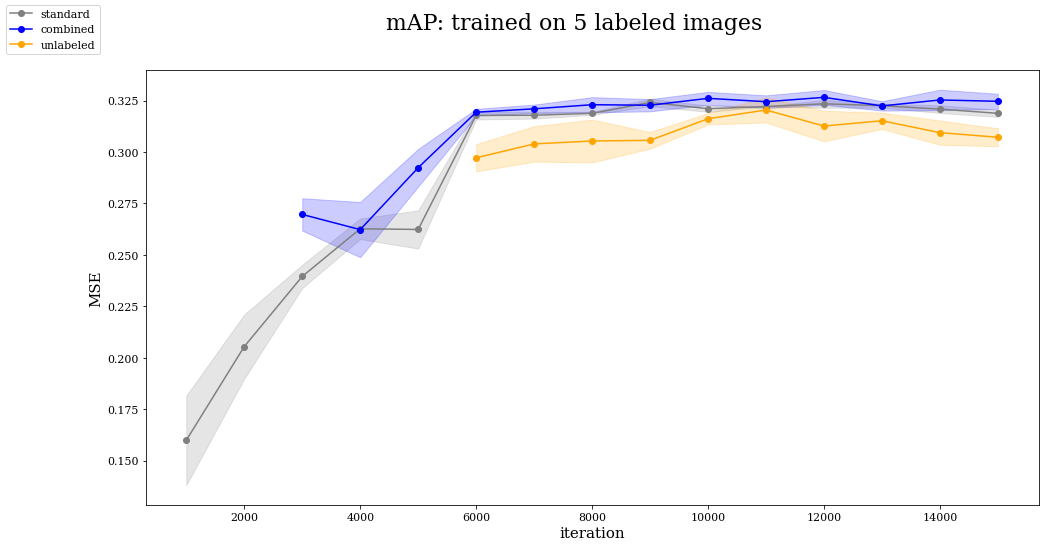

In [16]:
SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 22})
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=40)  # fontsize of the figure title
#plt.rc('font', 8)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
it_c = range(3000,15001,1000)
it1 = range(3000,15001,1000)
itu = range(6000,15001,1000)
ite = range(6000,14001,1000)
ita = range(1000,15001,1000)
fig, axes = plt.subplots(1,1,figsize=(16,8))
ax = axes
plt.xlabel("iteration")
plt.ylabel("MSE")
fig.suptitle("mAP: trained on 5 labeled images ",fontsize = 22)
colors = ['r','b','y','g']

#plt.plot(ita, sa1, '-o', c='grey', label="standard ap1")
#plt.plot(ita, sa2, '-o', c='grey', label="standard")
#plt.plot(ita, sa3, '-o', c='brown', label="standard ap3")
plt.plot(ita, sa4, '-o', c='grey', label="standard")
plt.fill_between(ita, np.array(sa4)-np.array(s_e), np.array(sa4)+np.array(s_e),alpha = .2,color='grey')


#plt.plot(it1, ca1, '-o', c='blue', label="combined ap1")
#plt.plot(it1, ca2, '-o', c='blue', label="combined")
#plt.plot(it1, ca3, '-o', c='green', label="combined ap3")
plt.plot(it1, ca4, '-o', c='blue', label="combined")
plt.fill_between(it1, np.array(ca4)-np.array(c_e), np.array(ca4)+np.array(c_e),alpha = .2,color='blue')


#plt.plot(itu, va1, '-o', c='orange', label="unlabeled ap1")
#plt.plot(itu, va2, '-o', c='orange', label="unlabeled")
#plt.plot(itu, va3, '-o', c='pink', label="unlabeled ap3")
plt.plot(itu, va4, '-o', c='orange', label="unlabeled")
plt.fill_between(itu, np.array(va4)-np.array(u_e), np.array(va4)+np.array(u_e),alpha = .2,color='orange')


#plt.plot(ita, bu[0:15], c='red', label="Sleap bottom up")
#plt.plot(ita, td[0:15], c='green', label="Sleap top down")
#ax.set_ylim(top = 35000,bottom = 5000)
fig.legend(loc='upper left')
fig.savefig("ap_5" +'.pdf')
plt.show()

In [17]:
f_aps = {"standard":{'va':s_25},
"combined":{'va':c_25},
"unlabeled":{'va':u_25}}

In [18]:
#with open('aps_25.pkl', 'wb') as f:
 #   pickle.dump(f_aps, f)

In [19]:
print(len(f_aps['standard']['va']))

4


In [20]:
with open('aps_5.pkl', 'rb') as f: #
    ap25 = pickle.load(f)
with open('aps_25.pkl', 'rb') as f:
    ap5 = pickle.load(f)

In [21]:
print(ap25['standard']['va'][0])

[[], [], []]


In [22]:
print(ap5['standard']['va'][0])

[[0.7584889664263109, 0.738134173265291, 0.7647235746732547, 0.7973200366569388, 0.8013700918468415, 0.788938498568089, 0.782983138023517, 0.7876304278481651, 0.7812347182774919, 0.7830567026278685, 0.779651305579224, 0.7827449893065741, 0.7809950076580559, 0.7774744228491977, 0.7820912888129151], [0.7238531542156001, 0.7792935311447806, 0.8192847135406118, 0.7949023428858376, 0.7842156978787481, 0.7779761017435476, 0.7805371770154496, 0.7746037155622248, 0.7743524589215127, 0.775997494769039, 0.7775421056856514, 0.7774628414460616, 0.7777679004231006, 0.777950481486529, 0.7751100900080111], [0.7002227619257159, 0.7558589433349687, 0.7978087507751277, 0.7636880860109181, 0.727934676297485, 0.76104404594377, 0.7621265709300266, 0.7583911829810988, 0.7656868348979294, 0.763317310736532, 0.7646496408401381, 0.767467667287164, 0.7648779600648365, 0.7616084490448933, 0.7639977556817322]]
